In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def IdeaHPF(height, width, radius=10):  # 理想高通滤波器传递函数
    u, v = np.mgrid[-1:1:2.0/height, -1:1:2.0/width]
    Dist = cv.magnitude(u, v)  # 距离
    D0 = radius / height  # 滤波器半径
    kernel = np.ones((height, width), np.uint8)
    kernel[Dist <= D0] = 0
    return kernel

In [3]:
def ButterworthHPF(height, width, radius=10, n=2.0):  # 巴特沃斯高通滤波器传递函数
    # 巴特沃斯高通滤波器：kern = 1/(1+(D0/D)^2n)
    u, v = np.mgrid[-1:1:2.0/height, -1:1:2.0/width]
    Dist = cv.magnitude(u, v)  # 距离
    D0 = radius/height  # 滤波器半径
    epsilon = 1e-8  # 防止被 0 除
    kernel = 1.0 / (1.0 + np.power(D0/(Dist+epsilon), 2*n))
    return kernel

In [4]:
def GaussianHPF(height, width, radius=10):  # 高斯高通滤波器传递函数
    # 高斯高通滤波器：kern = 1 - exp(-D^2/(2*D0^2))
    u, v = np.mgrid[-1:1:2.0/height, -1:1:2.0/width]
    Dist = cv.magnitude(u, v)  # 距离
    D0 = radius / height  # 滤波器半径
    kernel = 1 - np.exp(-(Dist**2)/(2*D0**2))
    return kernel

In [5]:
def DftFilter(image, D0=10, flag="GaussianHPF"):  #　最优扩充的快速傅立叶变换
    # (1) DFT 最优尺寸扩充，右侧下侧补 0，(h,w)->(hPad,wPad,2)
    height, width = image.shape[:2]
    hPad = cv.getOptimalDFTSize(height)  # DFT 最优尺寸
    wPad = cv.getOptimalDFTSize(width)
    imgPadded = cv.copyMakeBorder(image, 0, hPad-height, 0, wPad-width, cv.BORDER_CONSTANT)
    # (2) 快速傅里叶变换
    dftImg = cv.dft(imgPadded, flags=cv.DFT_COMPLEX_OUTPUT)  # DFT (hPad,wPad,2)
    # (3) 将低频分量移动到中心
    dftShift = np.fft.fftshift(dftImg)  # (hPad,wPad,2)
    # (4) 构造频域滤波器传递函数
    if flag=="GaussianHPF":  # 高斯高通滤波器
        filterHP = GaussianHPF(hPad, wPad, radius=D0)  # Gaussian 传递函数接口
    elif flag=="ButterworthHPF":   # 巴特沃斯高通滤波器
        filterHP = ButterworthHPF(hPad, wPad, radius=D0, n=2.25)
    else:  # 理想高通滤波器
        filterHP = IdeaHPF(hPad, wPad, radius=D0)
    filterDual = cv.merge([filterHP, filterHP])  # 拼接为2个通道：(hPad,wPad,2)
    # (5) 频率域修改傅里叶变换实现滤波
    dftFiltered = dftShift * filterDual  # 频域滤波 (hPad,wPad,2)
    # (6) 将低频逆移回图像四角，傅里叶逆变换
    iShift = np.fft.ifftshift(dftFiltered)  # 将低频逆转换回图像四角
    # (7) 傅里叶逆变换，使用幅度谱恢复图像
    iDft = cv.idft(iShift)  # 傅里叶逆变换 (hPad,wPad,2)
    iDftMag = cv.magnitude(iDft[:, :, 0], iDft[:, :, 1])  # 重建图像 (hPad,wPad)
    # (8) 截取左上角，转换为 CV_8U
    clipped = iDftMag[:height, :width]  # 切片获得原始图像尺寸 (h,w)
    imgFiltered = np.uint8(cv.normalize(clipped, None, 0, 255, cv.NORM_MINMAX))
    return imgFiltered

In [6]:
# 读取原始图像
img = cv.imread("Fig1001.png", flags=0)  # 灰度图像
imgFloat = img.astype(np.float32)  # 将图像转换成 float32
height, width = img.shape[:2]  # (450 512)

In [7]:
# 理想高通滤波器
IdeaHPF1 = DftFilter(imgFloat, D0=20, flag="IdeaHPF")
IdeaHPF2 = DftFilter(imgFloat, D0=100, flag="IdeaHPF")
# 高斯高通滤波器
GaussianHPF1 = DftFilter(imgFloat, D0=20, flag="GaussianHPF")
GaussianHPF2 = DftFilter(imgFloat, D0=100, flag="GaussianHPF")
# 巴特沃斯高通滤波器
ButterworthHPF1 = DftFilter(imgFloat, D0=20, flag="ButterworthHPF")
ButterworthHPF2 = DftFilter(imgFloat, D0=100, flag="ButterworthHPF")

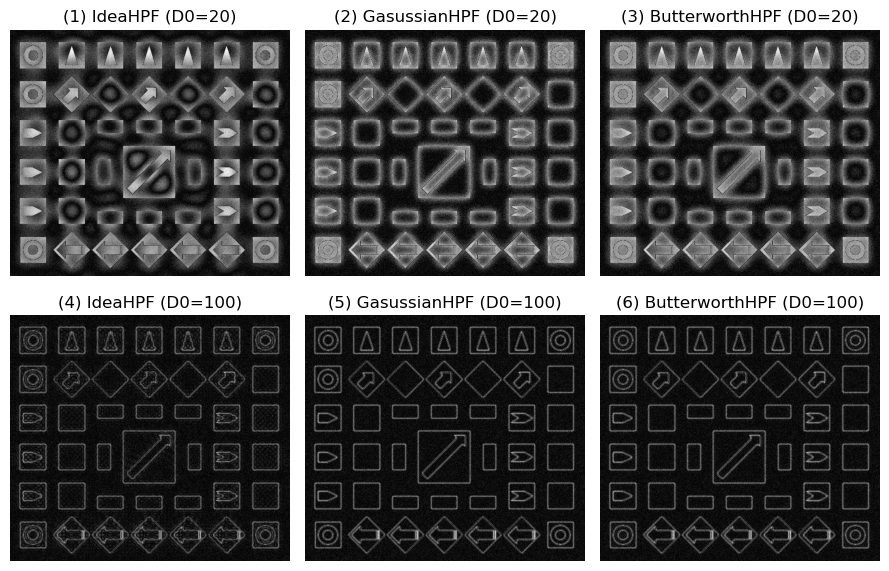

In [8]:
plt.figure(figsize=(9, 6))
plt.subplot(231), plt.title("(1) IdeaHPF (D0=20)"), plt.axis('off')
plt.imshow(IdeaHPF1, cmap='gray')
plt.subplot(232), plt.title("(2) GasussianHPF (D0=20)"), plt.axis('off')
plt.imshow(GaussianHPF1, cmap='gray')
plt.subplot(233), plt.title("(3) ButterworthHPF (D0=20)"), plt.axis('off')
plt.imshow(ButterworthHPF1, cmap='gray')
plt.subplot(234), plt.title("(4) IdeaHPF (D0=100)"), plt.axis('off')
plt.imshow(IdeaHPF2, cmap='gray')
plt.subplot(235), plt.title("(5) GasussianHPF (D0=100)"), plt.axis('off')
plt.imshow(GaussianHPF2, cmap='gray')
plt.subplot(236), plt.title("(6) ButterworthHPF (D0=100)"), plt.axis('off')
plt.imshow(ButterworthHPF2, cmap='gray')
plt.tight_layout()
plt.show()